# EDS 220: Data Wrangling with Rasters and False Color Imager

#### The purpose of this assignment to utilize false color satellite imagery to investigate the extent of wildfires in California in January, 2025. This anlaysis will walk through the steps necessary to display Landsay 8 satellite imagery overlayed with estimated perimeters of the 2025 LA County Palisades and Eaton Fires.

## Part 1: Installing libraries
Performing the data download, manipulation, and displays in this analysis requires the installation of several publicly-available software packages.

In [ ]:
import os                           # file and path handling
import pandas as pd                 # tabular data analysis
import matplotlib.pyplot as plt     # plotting and visualization
import xarray as xr                 # working with labeled multi-dimensional data (e.g., rasters)
import rioxarray as rio             # geospatial raster I/O and spatial operations
import netCDF4                      # reading NetCDF datasets
import geopandas as gpd             # vector geospatial data (shapefiles, geodataframes)
import numpy as np                  # numerical operations and arrays


## Part 2 - Fire Perimeter data
Shapefiles for the outline of LA County fires are provided by LA County. This step contains a method to download, join, project, and display fire perimeter data. Below are the data sources for each perimeter shapefile.

##### Eaton Fire
 - **File Name**: Eaton_Perimeter_20250121.shp
 - **Source**: https://egis-lacounty.hub.arcgis.com/datasets/
lacounty::palisades-and-eaton-dissolved-fire-perimeters-2025/explore?layer=0
 - **Publisher**: County of Los Angeles
 - **Date**: February 26, 2025

##### Palisades Fire
 - **File Name**: Palisades_Perimeter_20250121.shp
 - **Source**: https://egis-lacounty.hub.arcgis.com/datasets/lacounty::palisades-and-eaton-dissolved-fire-perimeters-2025/explore?layer=1&location=34.133066%2C-118.349606%2C9.60
 - **Publisher**: County of Los Angeles
 - **Date**: February 26, 2025

In [32]:
# Eaton
eaton = gpd.read_file(os.path.join('data',
                                   'Eaton_Perimeter_20250121',
                                   'Eaton_Perimeter_20250121.shp'))

# Palisades
palisades = gpd.read_file(os.path.join('data',
                                   'Palisades_Perimeter_20250121',
                                   'Palisades_Perimeter_20250121.shp'))

# Check CRS
print(f"Eaton CRS is: {eaton.crs}")
print(f"Palisades CRS is: {palisades.crs}")
assert eaton.crs == palisades.crs

# Check if projected
print(f"Eaton CRS is projected. {eaton.crs.is_projected}")
print(f"Palisades CRS is projected. {palisades.crs.is_projected}")
assert (eaton.crs.is_projected and palisades.crs.is_projected) == True

Eaton CRS is: EPSG:3857
Palisades CRS is: EPSG:3857
Eaton CRS is projected. True
Palisades CRS is projected. True


<Axes: >

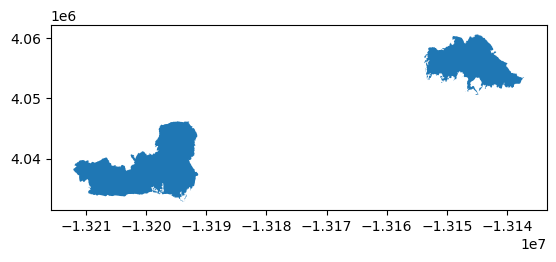

In [33]:
# Combine eaton and palisades shapefiles
fires = gpd.GeoDataFrame(pd.concat([eaton, palisades]))

# Confirm successful combination
fires.plot()


### Part 3 - NetCDF data import and exploration

In [34]:
# Create filepath
path = ('data/landsat8-2025-02-23-palisades-eaton.nc')

# Read in landsat netCDF4 data package with xarray
landsat = xr.open_dataset(path)

# Print data type
print(f"landsat data type is: {type(landsat)}")

# View bands, dimensions & coordinates
landsat


landsat data type is: <class 'xarray.core.dataset.Dataset'>


<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...
    spatial_ref  int64 8B ...

By printing `landsat` I was able to access the number of bands, the dimensions, and the CRS for x and y coordinate. The CRS for the x and y coordinates is EPSG:32611, and it is projected. I'm also able to tell that this data has 5 spectral bands including: red, green, nir08, and swir22. I was also able to see that the units of the CRS are meters, and the resolution is 30x30 meters.


### Part 4 - Restoring geospatial information

In [35]:
# Print CRS of landsat data
print(landsat.rio.crs)


None


a) Is this a geospatial object?
        **It's almost a geospatial object, but it doesn't have a CRS assigned right now so technically it is not**

b) Print the CRS by using accesing the `spatial_ref.crs_wkt` attribute of the dataset

In [36]:
# Print CRS
print(landsat.spatial_ref.crs_wkt)

PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]


c) Recover the geospatial information by using rio.srite_crs() and the spatial reference information from part b.

In [37]:
# Write CRS to WGS 84 / UTM zone 11N
landsat.rio.write_crs(["EPSG", "32611"], inplace=True)

# Print
print(landsat.rio.crs)

EPSG:32611


### 5) True color image

a) Without creating any new variables:
 - select the red, green and blue variables (in that order) of the `xarray.Dataset` holding the Landsat data,
 - convert it to a `numpy.array` using the `to_array()` method, and then
 - use `.plot.imshow()` to create an RGB image with the data. There will be two warnings, that's ok


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/Users/henryoliver/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


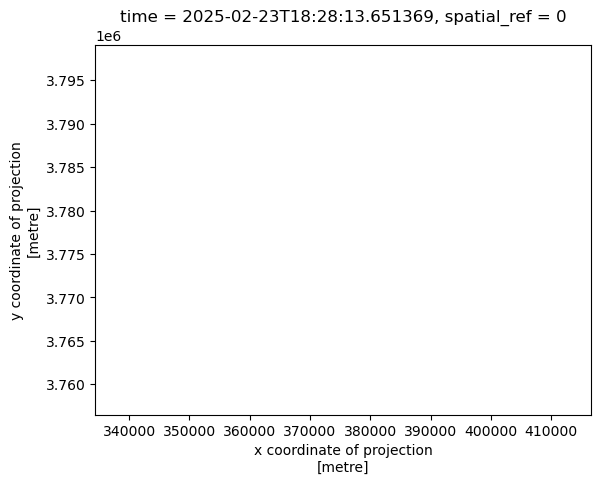

In [38]:
# Attempt to print true color image
landsat[['red', 'green', 'blue']].to_array().plot.imshow()

 b) Adjust the scale used for plotting the bands to get a true color image. HINT: Check the robust parameter. The issue here is the clouds: their RGB values are outliers and cause the other values to be squished when plotting.

/Users/henryoliver/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


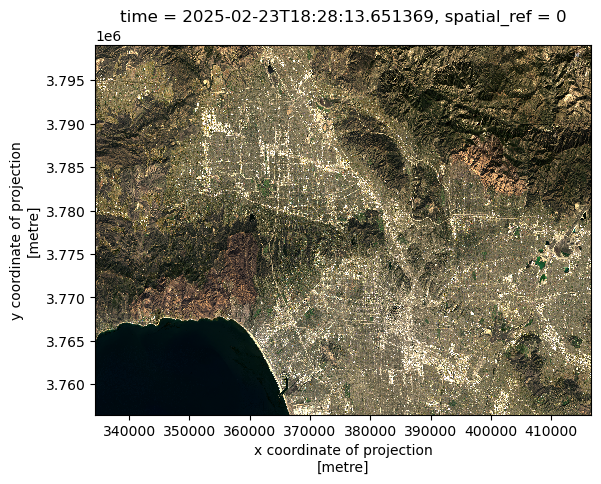

In [39]:
# Print true color image 
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

c) To resolve the other warning, identify which bands have `nan` values. HINT: There are many ways of doing so. ne option is to use the `numpy.isnan()`.

In [40]:
# Access bands with NA values
np.isnan(landsat)

<xarray.Dataset> Size: 19MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B 2025-02-23T18:28:13.651369
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) bool 4MB False False False False ... False False False
    green        (y, x) bool 4MB False False False False ... False False False
    blue         (y, x) bool 4MB False False False False ... False False False
    nir08        (y, x) bool 4MB False False False False ... False False False
    swir22       (y, x) bool 4MB False False False False ... False False False

d) use `.fillna()` method for `xarray.Dataset` to substitute the any `nan` values in the Landsat data for zero

In [41]:
landsat.fillna(0)

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B 2025-02-23T18:28:13.651369
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) float32 16MB 1.024e+04 9.886e+03 ... 1.019e+04 9.967e+03
    green        (y, x) float32 16MB 9.93e+03 9.687e+03 ... 9.984e+03 9.662e+03
    blue         (y, x) float32 16MB 9.29e+03 9.183e+03 ... 9.49e+03 9.187e+03
    nir08        (y, x) float32 16MB 1.331e+04 1.313e+04 ... 1.287e+04 1.306e+04
    swir22       (y, x) float32 16MB 1.43e+04 1.437e+04 ... 1.406e+04 1.329e+04

e) Create a new true color image that gets plotted without warnings

/Users/henryoliver/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


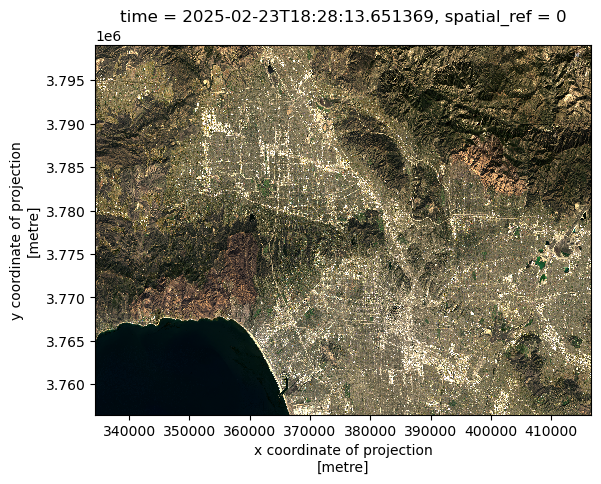

In [42]:
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

f) In a markdown cell write a brief explanation comparing the outputs for parts (a) and (e)

The output in part a) showed a blank plot, that was not printing any of the bands that I had selected. According to my google searches, this is because once the minimum, maximum and NA data for each band were not specified, and as a result the bands could not be printed. Consequently, only the x & y data was plotted. In part e) my plot shows a realistic true color image without warnings. This is because by adding the `robust = True` argument to my `im.show()` method, the vmin and vmax values for each band are specified, which allows the bands to be displayed accurately. Also, by turning the NA values to 0, we can eliminate the warning about NA values, without comprimising our image.

### 6) False color image

Without creating any new variables, create a false color image by plotting the short-wave infrared (swir22), near-infrared, and red variables (in that order)

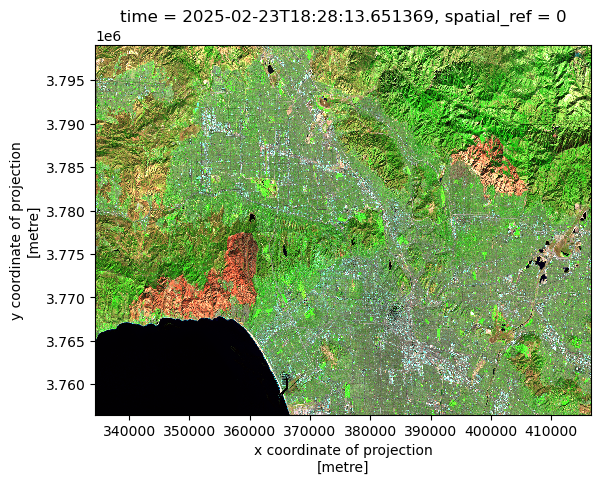

In [ ]:
# Display false color image
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True)

### 7) Map
a) Create a map showing the shortwave infrared/near-infrared/red false color image together with both fire perimeters.
  - Add a title and annotations to your figure

In [44]:
# Make sure our fires and imagery have the same CRS
fires = fires.to_crs(landsat.rio.crs)

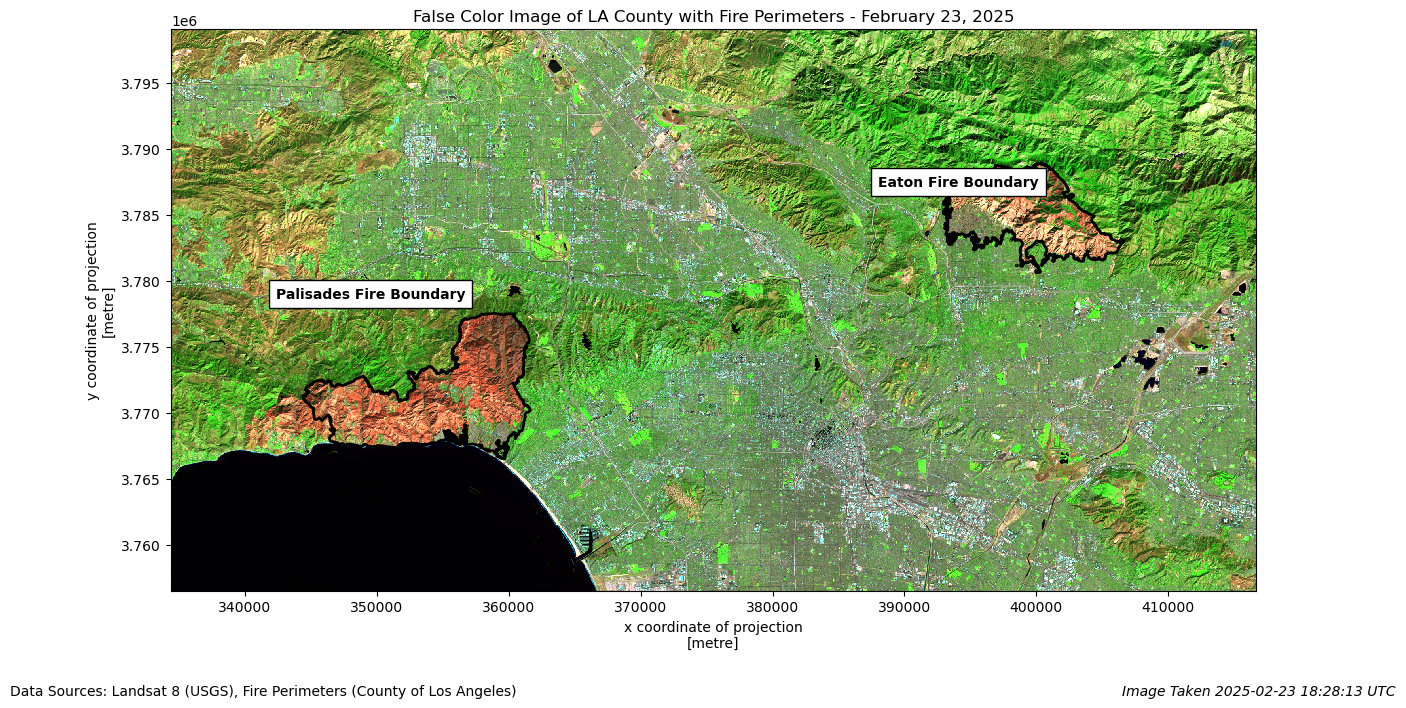

In [ ]:
# Create plot
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Plot LANDSAT false color imager
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow( # Select false color bands
    robust=True,
    ax=ax,
    add_colorbar = False,
    zorder = 0)
# Add title
ax.set_title("False Color Image of LA County with Fire Perimeters - February 23, 2025")

# FIRE PERIMETERS ON TOP
fires.plot(
    ax=ax,
    edgecolor='black',
    facecolor= "none",
    linewidth=2,
    alpha= 1,
    zorder=1
)

# Add Map data labels
plt.figtext(x=.63, y=.65, s="Eaton Fire Boundary", weight='bold',
            bbox = {'facecolor': 'white', #Add text border
                    'pad':5})
plt.figtext(x=.2,  y=.51, s="Palisades Fire Boundary", weight='bold',
            bbox = {'facecolor': 'white', #Add text border
                    'pad':5})

# Add Data Citation
fig.text(
    0.01, 0.01, 
    "Data Sources: Landsat 8 (USGS), Fire Perimeters (County of Los Angeles)", 
    fontsize=10,
    ha='left', 
    va='bottom',
    style = 'italic'
)

# Add Timestamp
fig.text(
    1, 0.01, 
    "Image Taken 2025-02-23 18:28:13 UTC", 
    fontsize=10,
    ha='right', 
    va='bottom',
    style = 'italic'
)
plt.show()

